In [38]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools

import os
import cv2

import numpy as np

In [39]:
path = 'emotion_data' # 데이터셋 경로
image_size = 128 # 이미지 크기
test_size = 0.15 # test set 비율

# 데이터셋 내 폴더들을 리스트로 추출
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

# 각 폴더 내 이미지 파일들을 불러와서 흑백으로 변환하고 라벨링
images = []
labels = []
for i, folder in enumerate(folders):
    print(i, folder)
    image_names = os.listdir(os.path.join(path, folder))
    for image_name in image_names:
        image_path = os.path.join(path, folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)
        labels.append(i)

# 불러온 이미지와 라벨을 numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# train과 test set을 나눔
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

0 frown
1 smile
2 neutral
3 sad
4 Surprised


In [28]:
# 크기 확인
print('x_train : {}'.format(X_train.shape))
print('Y-train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(X_test.shape))

x_train : (4232, 128, 128)
Y-train shape: (4232,)
x_test shape: (747, 128, 128)


In [29]:
# train과 valid 파일 분배배
X_train, X_valid, y_train, y_valid= train_test_split(
    X_train, y_train, test_size=.1766, random_state=1234,)

In [40]:

#input size와 shape 확인
im_rows=128
im_cols=128
batch_size=64
im_shape=(im_rows, im_cols, 1)
print(im_shape)
print('x_train shape: {}'.format(X_train.shape))
print('x_test shape: {}'.format(X_valid.shape))

(128, 128, 1)
x_train shape: (4232, 128, 128)
x_test shape: (748, 128, 128, 1)


In [31]:
#cnn 모델 생성

cnn_model= Sequential([
    Conv2D(filters=32, kernel_size=9, activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=7, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(5, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

/home/yejin/.local/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 120, 120, 32)      2624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_141 (Conv2D)         (None, 54, 54, 256)       401664    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 256)      0         
 2D)                                                             
                                                                 
 conv2d_142 (Conv2D)         (None, 23, 23, 256)       1638656   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 256)     

In [33]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# val_loss가 epoch 10 이상 오르지 않으면 stop
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 콜백 함수 정의
checkpoint = ModelCheckpoint('best_emotion_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# 모델 훈련 과정에서 콜백 함수를 사용하여 최고의 성능을 보인 모델을 저장

history=cnn_model.fit(
    np.array(X_train), np.array(y_train), batch_size=64,
    epochs=250, verbose=2,
    validation_data=(np.array(X_valid),np.array(y_valid)),
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/250

Epoch 1: val_loss improved from inf to 1.60123, saving model to best_emotion_model.h5
55/55 - 127s - loss: 1.9500 - accuracy: 0.1989 - val_loss: 1.6012 - val_accuracy: 0.2072 - 127s/epoch - 2s/step
Epoch 2/250

Epoch 2: val_loss improved from 1.60123 to 1.59261, saving model to best_emotion_model.h5
55/55 - 124s - loss: 1.6183 - accuracy: 0.2121 - val_loss: 1.5926 - val_accuracy: 0.2340 - 124s/epoch - 2s/step
Epoch 3/250

Epoch 3: val_loss improved from 1.59261 to 1.52497, saving model to best_emotion_model.h5
55/55 - 124s - loss: 1.5917 - accuracy: 0.2408 - val_loss: 1.5250 - val_accuracy: 0.3583 - 124s/epoch - 2s/step
Epoch 4/250

Epoch 4: val_loss improved from 1.52497 to 0.94858, saving model to best_emotion_model.h5
55/55 - 124s - loss: 1.3456 - accuracy: 0.4061 - val_loss: 0.9486 - val_accuracy: 0.6578 - 124s/epoch - 2s/step
Epoch 5/250

Epoch 5: val_loss improved from 0.94858 to 0.62141, saving model to best_emotion_model.h5
55/55 - 121s - loss: 0.9251 - accuracy: 0

In [34]:
# test에 대한 loss와 accuracy 확인인
scor = cnn_model.evaluate( np.array(X_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

test los 0.0312
test acc 0.9866


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


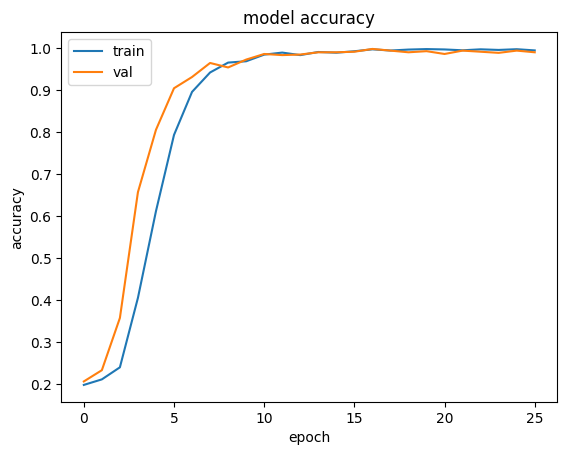

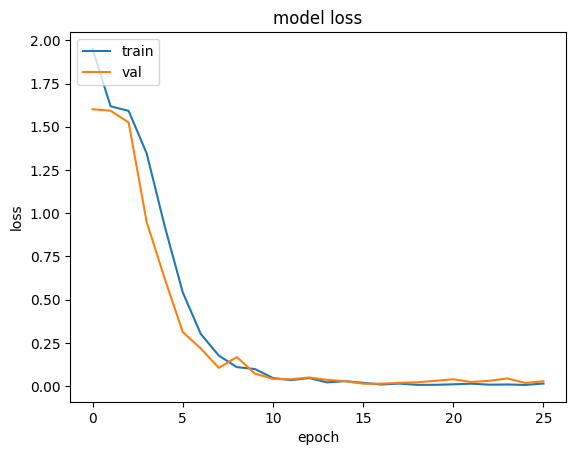

In [35]:
# 히스토리에 있는 키들 출력력
print(history.history.keys())
# accuracy의 history를 그래프로 보여 줌
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss history를 그래포로 보여 줌
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()